<a href="https://colab.research.google.com/github/Gus-1003/Geoestatistica_Estudos_Dados/blob/main/Semagraria/Patricia_Aula2_aede.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análise exploratória de dados espaciais - AEDE

<br>
Municípios grandes produtores de alguma cultura tendem a estar próximos de municípios também produtores dessa cultura ou de municípios que não o produzem? O objetivo da análise exploratória de dados espaciais (AEDE) é responder a esse tipo de questão. De forma mais geral, a questão é qual a a associação entre o valor de certa variável em um lugar e os valores dessa mesma variável nos lugares vizinhos. Localidades com valores semelhantes de determinada variável tendem a estar próximas? Para isso, ela mede a autocorrelação espacial, por meio do $I$ de Moran.

In [1]:
!pip install geopandas==0.8.2
!pip install --upgrade pyshp
!pip install shapely  ==1.7.0
!pip install --upgrade descartes
!pip install mapclassify==2.3.0 libpysal==4.3.0 splot==1.1.3
!pip install esda
!pip install pysal

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 962 kB 5.4 MB/s 
     |████████████████████████████████| 6.3 MB 37.5 MB/s 
     |████████████████████████████████| 16.7 MB 39.9 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 46 kB 1.4 MB/s 
ERROR: Invalid requirement: '==1.7.0'
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.4 MB 8.4 MB/s 
     |████████████████████████████████| 116 kB 50.5 MB/s 
     |████████████████████████████████| 220 kB 46.4 MB/s 
     |████████████████████████████████| 60 kB 7.3 MB/s 
     |████████████████████████████████| 179 kB 57.0 MB/s 
  Created wheel for libpysal: filename=libpysal-4

In [2]:
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.formula.api as sm

# para gráficos
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# para a análise de dados espaciais
import geopandas as gp
import pysal as ps
import splot
import mapclassify as mc
from libpysal.weights import Queen
from libpysal import weights
from esda import Moran, Moran_Local, G_Local
from splot.esda import plot_moran, moran_scatterplot, lisa_cluster, plot_local_autocorrelation

# links com arquivos úteis
link = 'https://raw.githubusercontent.com/lincolnfrias/dados/master/'
link_p = 'https://raw.githubusercontent.com/patriciasiqueira/patriciasiqueira.github.io/master/arquivos/'

In [3]:
# ler dados de interesse
dados = pd.read_csv(link_p+'qtde-22.csv', encoding='latin1')
# quantidade produzida em toneladas em 2017

# para ler um arquivo salvo no computador
# ir primeiro em > e Files
# dados = pd.read_csv('qtde_22.csv', encoding='latin1')

In [4]:
# nomes das variáveis
dados.columns

Index(['ibge7', 'mun', 'nome_meso', 'abacate', 'abacaxi', 'alho', 'amendoim',
       'arroz', 'aveia', 'banana', 'batata-doce', 'batata-inglesa',
       'cafe_total', 'cafe_arab', 'cana', 'feijao', 'girassol', 'laranja',
       'maracuja', 'milho', 'soja', 'sorgo', 'tomate', 'trigo', 'uva'],
      dtype='object')

In [5]:
# número de linhas e colunas do dataframe
dados.shape

(853, 25)

In [6]:
# mostrar algumas linhas do dataframe
dados.head(3)

,ibge7,mun,nome_meso,abacate,abacaxi,alho,amendoim,arroz,aveia,banana,...,feijao,girassol,laranja,maracuja,milho,soja,sorgo,tomate,trigo,uva
0,3100104,Abadia dos Dourados,Triângulo Mineiro/Alto Paranaíba,0,0,0,0,2,0,47,...,18,0,0,0,8028,11685,1212,100,0,0
1,3100203,Abaeté,Central Mineira,0,540,0,0,8,0,28,...,0,0,0,63,4680,1404,0,0,0,0
2,3100302,Abre Campo,Zona da Mata,0,0,0,0,0,0,50,...,170,0,0,0,780,0,0,0,0,0


In [7]:
# renomear colunas
# 'ibge7' será 'mun' (código do município)
# 'mun' será 'município' (nome do município)

dados.rename(columns={'mun': 'municipio'}, inplace=True)  # inplace = True modifica o dataframe
dados.rename(columns={'ibge7': 'mun'}, inplace=True)

In [8]:
# ler shapefile
link = 'https://raw.githubusercontent.com/lincolnfrias/dados/master/mg.json'
geodf = gp.read_file(link)

In [9]:
geodf.head()

,NM_MUNICIP,CD_GEOCMU,geometry
0,ABADIA DOS DOURADOS,3100104,"POLYGON ((-47.42967 -18.16543, -47.42307 -18.1..."
1,ABAETÉ,3100203,"POLYGON ((-45.13930 -19.21048, -45.15975 -19.1..."
2,ABRE CAMPO,3100302,"POLYGON ((-42.31071 -20.14279, -42.32217 -20.1..."
3,ACAIACA,3100401,"POLYGON ((-43.02387 -20.41022, -43.03283 -20.4..."
4,AÇUCENA,3100500,"POLYGON ((-42.36208 -18.92569, -42.36636 -18.9..."


In [10]:
# mesclar shapefile com dataframe
# usando a coluna mun
geodf.rename(columns={'CD_GEOCMU': 'mun'}, inplace=True)  # mudar nome da coluna com cód. para 'mun'
geodf['mun'] = geodf.mun.astype(int)  # transformar códigos em inteiros
mg = pd.merge(geodf, dados, on='mun', suffixes=('', '_y'))  # mesclar o dataframe e o shapefile
mg.shape

(853, 27)

In [11]:
# ver objeto resultante (dataframe + shapefile)
mg.head(3)

,NM_MUNICIP,mun,geometry,municipio,nome_meso,abacate,abacaxi,alho,amendoim,arroz,...,feijao,girassol,laranja,maracuja,milho,soja,sorgo,tomate,trigo,uva
0,ABADIA DOS DOURADOS,3100104,"POLYGON ((-47.42967 -18.16543, -47.42307 -18.1...",Abadia dos Dourados,Triângulo Mineiro/Alto Paranaíba,0,0,0,0,2,...,18,0,0,0,8028,11685,1212,100,0,0
1,ABAETÉ,3100203,"POLYGON ((-45.13930 -19.21048, -45.15975 -19.1...",Abaeté,Central Mineira,0,540,0,0,8,...,0,0,0,63,4680,1404,0,0,0,0
2,ABRE CAMPO,3100302,"POLYGON ((-42.31071 -20.14279, -42.32217 -20.1...",Abre Campo,Zona da Mata,0,0,0,0,0,...,170,0,0,0,780,0,0,0,0,0


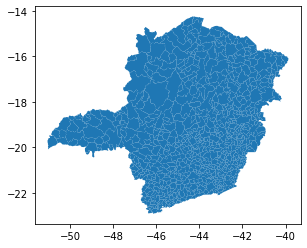

In [12]:
mg.plot();

In [13]:
mg.columns

Index(['NM_MUNICIP', 'mun', 'geometry', 'municipio', 'nome_meso', 'abacate',
       'abacaxi', 'alho', 'amendoim', 'arroz', 'aveia', 'banana',
       'batata-doce', 'batata-inglesa', 'cafe_total', 'cafe_arab', 'cana',
       'feijao', 'girassol', 'laranja', 'maracuja', 'milho', 'soja', 'sorgo',
       'tomate', 'trigo', 'uva'],
      dtype='object')

In [14]:
variavel = 'soja'

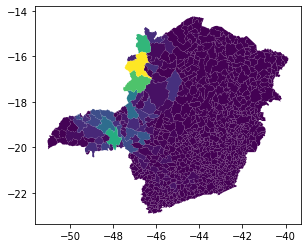

In [15]:
# mapa temático - simples
mg.plot(variavel);

Esquemas de cores: cmap (https://matplotlib.org/stable/tutorials/colors/colormaps.html)

- PuBu

- GnBu

- Oranges

- BuGn

- Purples

- YlOrBr


/usr/local/lib/python3.7/dist-packages/mapclassify/classifiers.py:239: UserWarning: Warning: Not enough unique values in array to form k classes
  "Warning: Not enough unique values in array to form k classes", UserWarning
/usr/local/lib/python3.7/dist-packages/mapclassify/classifiers.py:241: UserWarning: Warning: setting k to 3
  Warn("Warning: setting k to %d" % k_q, UserWarning)


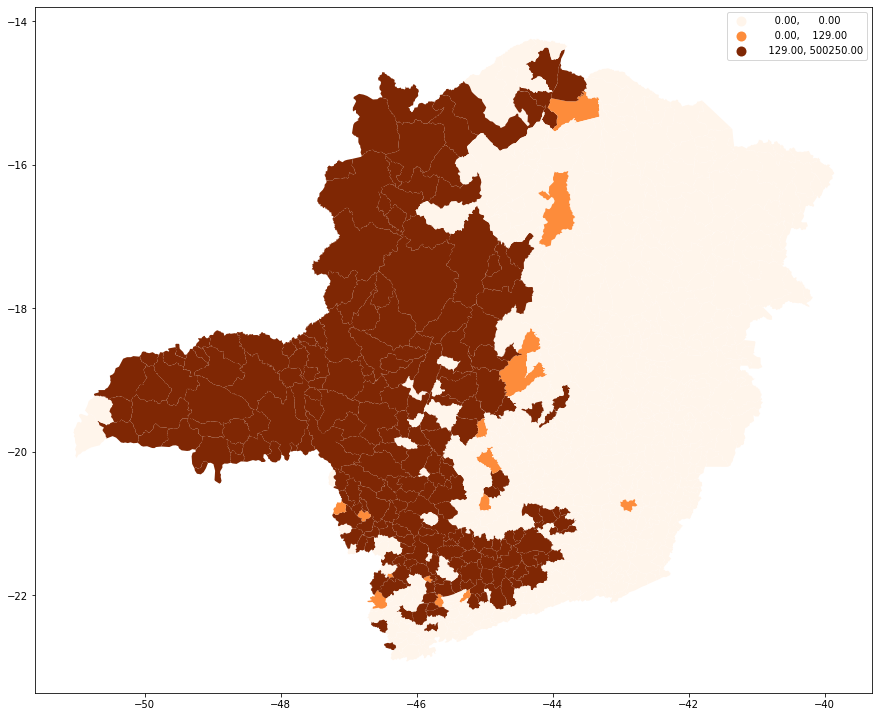

In [16]:
# mapa temático - com opções
# scheme='Quantiles' ou 'Equal_Interval'
# quantiles: atribui mesma quantidade de valores para cada categoria. Apesar de esconder valores extremos,
# pode se tornar mais informativa se a distribuição for assimétrica
# perceber as diferenças entre os esquemas: cmap='PuBu', por exemplo


mg.plot(column=variavel, figsize=(15, 13), scheme='quantiles', legend=True, k=4, cmap='Oranges');

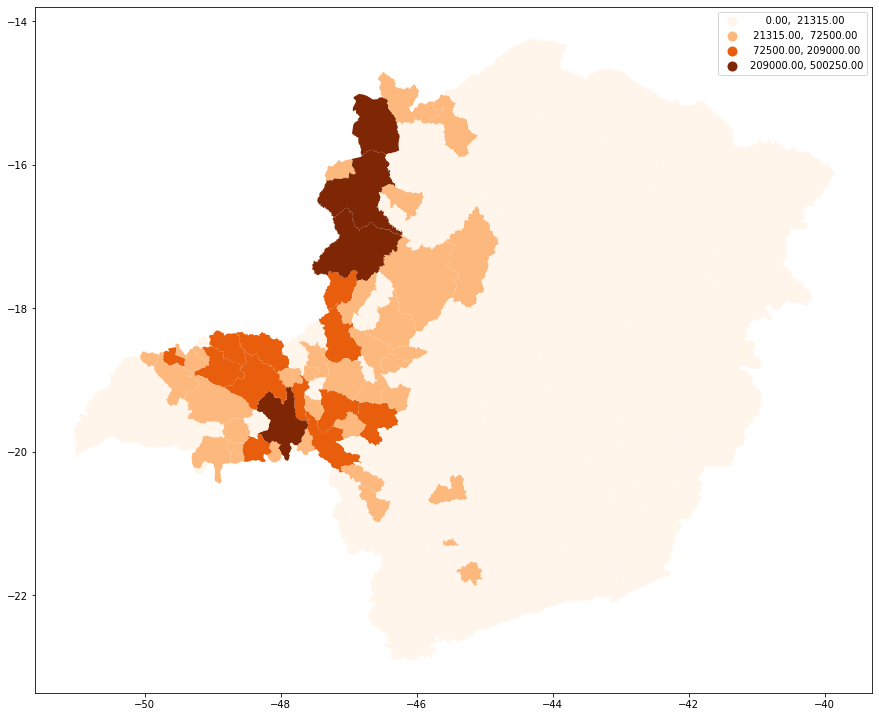

In [17]:
# mapa temático - com opções
# scheme='equal_interval', 'fisher_jenks'
mg.plot(column=variavel, figsize=(15, 13), scheme='fisher_jenks', legend=True, k=4, cmap='Oranges');

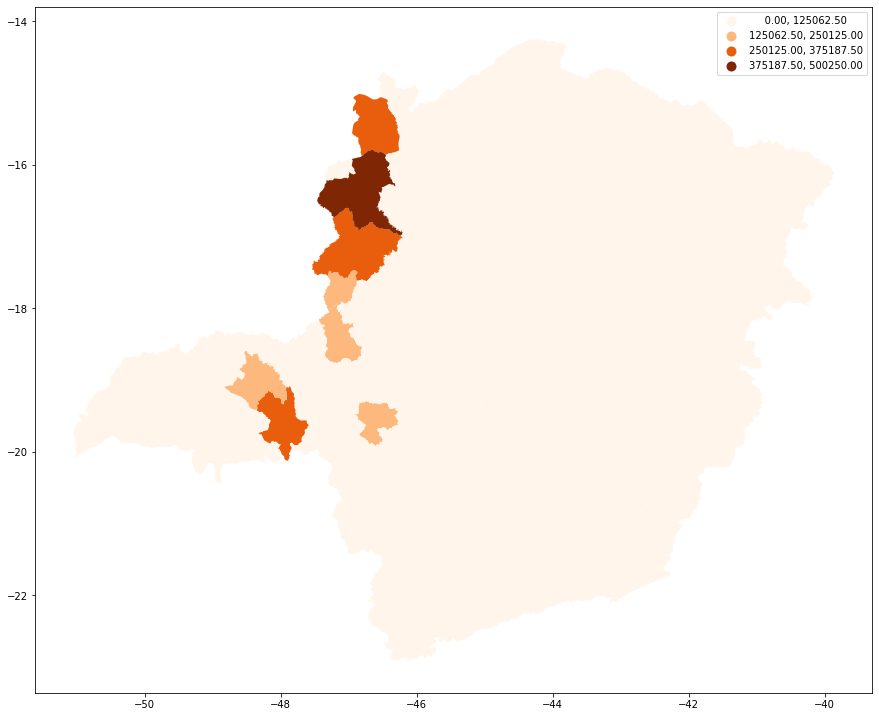

In [18]:
# mapa temático - com opções
# escolher diferentes esquemas de cores
mg.plot(column=variavel, figsize=(15, 13), scheme='equal_interval', legend=True, k=4, cmap='Oranges');

In [19]:
# obter matriz de vizinhança no formato queen
w = Queen.from_dataframe(mg)
w.transform = 'r'

# I de Moran

Estatística mais utilizada para medir a autocorrelação espacial. Ela mede a relação do desvio padronizado de uma variável numa área com o desvio padronizado das áreas vizinhas para a mesma variável:

$$I=\frac{N}{S_{0}}\frac{\displaystyle\sum_{i=1}^{n}\sum_{j=1}^{n}w_{ij}z_{i}z_{j}}{\displaystyle\sum_{i=1}^{n}z^{2}_{i}},$$
em que:

- $z_i = y_i - \bar{y}$ representa o desvio em relação à média da variável.
- $y_i$: valor da variável em um determinado local $i$
- $N$: número de observações
- $S_0 = \sum\sum w_{ij}$
- $E[I] = -1/(N - 1) \approx 0$
            
Se o valor-$p$ referente ao teste do $I$ de Moran for significativo, podemos olhar para o valor da estatística $I$ e concluir:

- $I > 0$: autocorrelação espacial positiva (*clusters* espaciais - HH, LL)
- $I < 0$: autocorrelação espacial negativa (*outliers* espaciais - HL, LH)

In [20]:
# calcular I de Moran global para a variável escolhida
y = mg[variavel].values
moran = Moran(y, w)
moran.I

0.4983387682998699

In [21]:
# valor-p
moran.p_sim

0.001

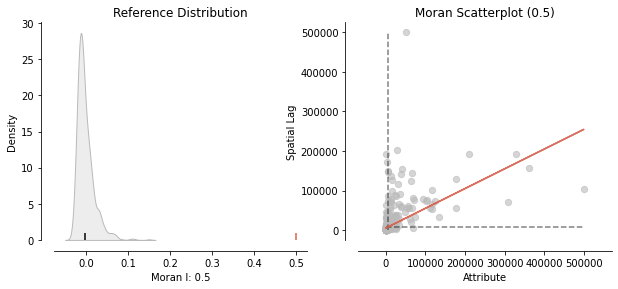

In [22]:
# diagrama de dispersão de Moran
plot_moran(moran, zstandard=False, figsize=(10,4));

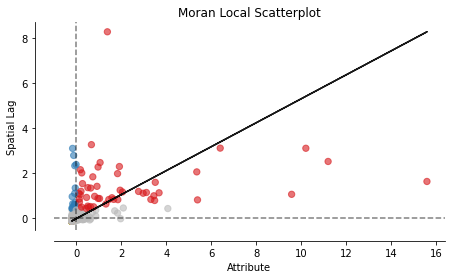

In [23]:
moran_loc = Moran_Local(y, w)
moran_scatterplot(moran_loc, p=0.05);

### LISA

- Estatística para detectar padrões locais de autocorrelação espacial: *Local Indicator of Spatial Association* (LISA), ou $I$ de Moran local  
- Permite verificar se há agrupamentos espaciais estatisticamente significativos
- Útil quando a estatística $I$ de Moran global for significativa

$$I_{i}=z_{i}\sum_{j=1}^{j}w_{ij}y_{j}$$  

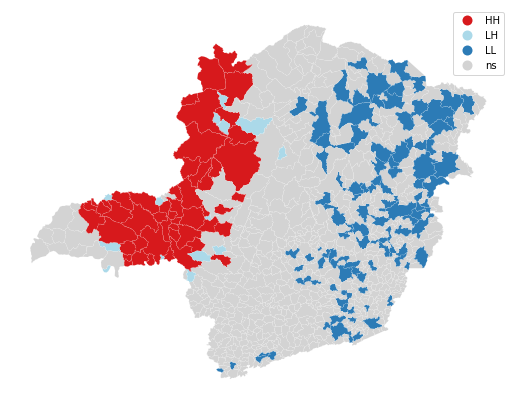

In [24]:
lisa_cluster(moran_loc, mg, p=0.05, figsize = (9,9));

/usr/local/lib/python3.7/dist-packages/mapclassify/classifiers.py:239: UserWarning: Warning: Not enough unique values in array to form k classes
  "Warning: Not enough unique values in array to form k classes", UserWarning
/usr/local/lib/python3.7/dist-packages/mapclassify/classifiers.py:241: UserWarning: Warning: setting k to 3
  Warn("Warning: setting k to %d" % k_q, UserWarning)


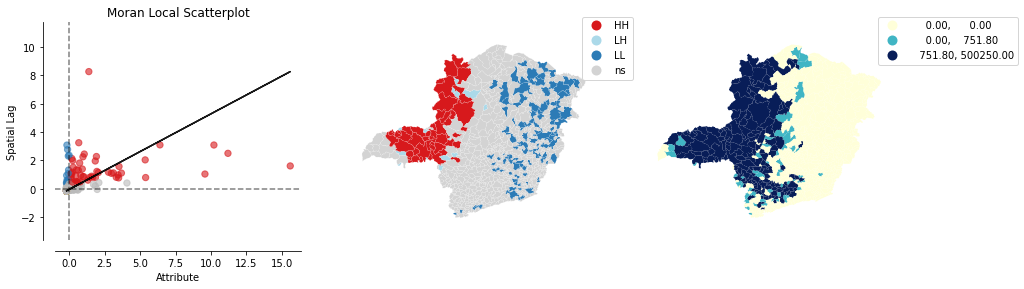

In [25]:
plot_local_autocorrelation(moran_loc, mg, variavel);